In [1]:
for i in range(10):
    nb_j = 12 * 4**i
    print(i, nb_j)

0 12
1 48
2 192
3 768
4 3072
5 12288
6 49152
7 196608
8 786432
9 3145728


In [2]:
import healpy
import torch
import hipster

i = 0
hierarchy = 1

for j in range(12 * 4**i):
    vectors = torch.zeros(
        (hierarchy**2, 3), dtype=torch.float32
    )  # prepare vor n*n subtiles
    for sub in range(
        hierarchy**2
    ):  # calculate coordinates for all n*n subpixels
        vector = healpy.pix2vec(
            2**i * hierarchy, j * hierarchy**2 + sub, nest=True
        )
        vectors[sub] = torch.tensor(vector).reshape(1, 3).type(dtype=torch.float32)
    print(j, vectors)

0 tensor([[0.5270, 0.5270, 0.6667]])
1 tensor([[-0.5270,  0.5270,  0.6667]])
2 tensor([[-0.5270, -0.5270,  0.6667]])
3 tensor([[ 0.5270, -0.5270,  0.6667]])
4 tensor([[1., 0., 0.]])
5 tensor([[6.1232e-17, 1.0000e+00, 0.0000e+00]])
6 tensor([[-1.0000e+00,  1.2246e-16,  0.0000e+00]])
7 tensor([[-1.8370e-16, -1.0000e+00,  0.0000e+00]])
8 tensor([[ 0.5270,  0.5270, -0.6667]])
9 tensor([[-0.5270,  0.5270, -0.6667]])
10 tensor([[-0.5270, -0.5270, -0.6667]])
11 tensor([[ 0.5270, -0.5270, -0.6667]])


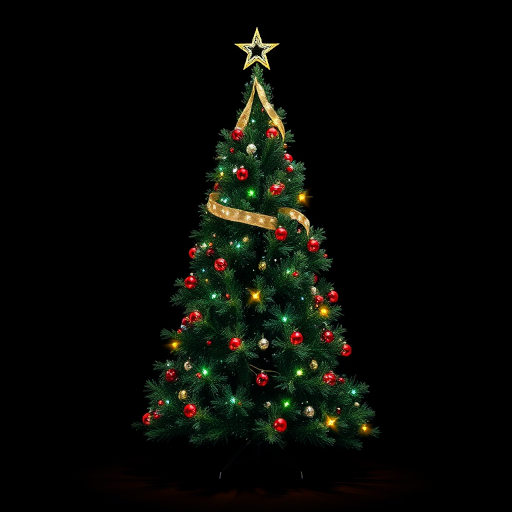

In [3]:
from PIL import Image

# Read the PNG file
image = Image.open('xmas.png').convert('RGB')
image

In [4]:
import numpy as np

data = np.array(image)
data.shape

(512, 512, 3)

In [13]:
import math

def calculate_pixels(matrix, pixel):
    size = matrix.shape[0]
    if size > 1:
        matrix[: size // 2, : size // 2] = calculate_pixels(
            matrix[: size // 2, : size // 2], pixel * 4
        )
        matrix[size // 2 :, : size // 2] = calculate_pixels(
            matrix[size // 2 :, : size // 2], pixel * 4 + 1
        )
        matrix[: size // 2, size // 2 :] = calculate_pixels(
            matrix[: size // 2, size // 2 :], pixel * 4 + 2
        )
        matrix[size // 2 :, size // 2 :] = calculate_pixels(
            matrix[size // 2 :, size // 2 :], pixel * 4 + 3
        )
    else:
        matrix = pixel
    return matrix

def distortion_correction(data, order, pixel, output_size):
    # data = np.swapaxes(data, 0, 2)
    result = np.zeros((output_size, output_size, 3))
    healpix_pixel = np.zeros((output_size, output_size), dtype=np.int64)
    healpix_pixel = calculate_pixels(healpix_pixel, pixel)
    center_theta, center_phi = healpy.pix2ang(2**order, pixel, nest=True)
    size = data.shape[0]
    max_theta = max_phi = 2 * math.pi / (4 * 2**order) / 2
    for x in range(output_size):
        for y in range(output_size):
            target_theta, target_phi = healpy.pix2ang(2**order * output_size, healpix_pixel[x, y], nest=True)
            delta_theta = target_theta - center_theta
            if center_phi == 0 and target_phi > math.pi:
                delta_phi = (target_phi - center_phi - 2 * math.pi) * math.sin(
                    target_theta
                )
            else:
                delta_phi = (target_phi - center_phi) * math.sin(target_theta)
            target_x = int(size // 2 + delta_phi / max_phi * (size // 2 - 1))
            target_y = int(size // 2 + delta_theta / max_theta * (size // 2 - 1))
            if (
                target_x >= 0
                and target_y >= 0
                and target_x < size
                and target_y < size
            ):
                result[x, y] = data[target_x, target_y]
    return result

In [14]:
data = distortion_correction(data, 0, 0, 512)

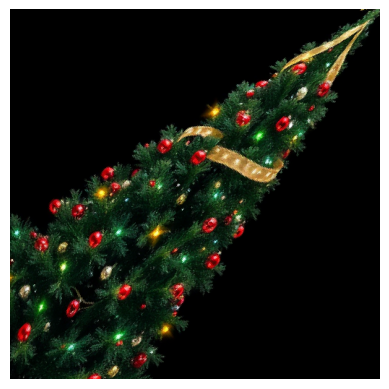

In [15]:
import matplotlib.pyplot as plt

plt.imshow(data.astype(np.uint8))
plt.axis('off')  # Hide the axis
plt.show()